# Lorentz invariant networks

In this exercise we will investigate neural network architectures that are
- functions of a set of 4-(momentum)-vectors $p_1, p_2, \dots, p_n$
- permutation invariant
- invariant under Lorentz transformations

$$
\mathrm{net}(p_1, p_2, \dots, p_n) = \mathrm{net}(p_{\sigma(1)}, p_{\sigma(2)}, \dots, p_{\sigma(n)}) = \mathrm{net}(\Lambda p_1, \Lambda p_2, \dots, \Lambda p_n)
$$

For permutations $\sigma$ and Lorentz transformations $\Lambda$, meaning rotations in space, e.g. in the x-y plane:

$$
\Lambda_{\mathrm{rot},xy}=\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & \cos(\phi) & -\sin(\phi) & 0\\
0 & \sin(\phi) & \cos(\phi) & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
$$

and boosts, e.g. in x direction

$$
\Lambda_{\mathrm{boost},x}=\begin{pmatrix}
\gamma & -\beta\gamma & 0 & 0\\
-\beta\gamma & \gamma & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
$$

We will try to implement the PELICAN model (in particular the minimal variant *nanoPELICAN*) as an example for this. References:
- [PELICAN](https://arxiv.org/abs/2307.16506)
- [nanoPELICAN](https://arxiv.org/abs/2310.16121)
- [ML4Jets2024 talsk](https://indico.cern.ch/event/1253794/contributions/5588625/attachments/2748386/4783069/ML4Jets23_PELICAN.pdf)
- [nanoPELICAN code on github](https://github.com/abogatskiy/PELICAN-nano)

## Data loading

In [1]:
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

We will use again the TopTagging dataset, this time with 100k events

In [2]:
url_train = "https://syncandshare.lrz.de/dl/fi99w9JNTjbbYBmoK11oP3/train_100k.npz"

In [3]:
def load(url):
    with fsspec.open(url) as f:
        data = {k: v[:] for k, v in np.load(f).items()}
    arrays = []
    start = 0
    for size in data["sizes"]:
        stop = start + size
        arrays.append(data["p4"][start:stop])
        start = stop
    return arrays, data["y"]

This time we will use a represantation without any padding and will do the padding dynamically instead:

In [7]:
arrays, y = load(url_train)

In [10]:
len(arrays)

100000

The momentum vectors are given as (E, px, py, pz):

In [11]:
p4 = arrays[0]
p4.shape

(23, 4)

In [12]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

We define a torch Dataset that retrieves data for a single event:

In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, arrays, y):
        self.arrays = arrays
        self.y = y

    def __len__(self):
        return len(self.arrays)

    def __getitem__(self, i):
        return self.arrays[i], self.y[i]

In [14]:
ds = Dataset(arrays, y)

In [15]:
event = ds[0]
# x, y
event[0].shape, event[1]

((23, 4), 0)

The torch DataLoader will take care of creating batches from it, but we have to tell it how by defining a `collate_fn` that does the padding for us and also determines which entries are masked:

In [16]:
def collate_fn(batch):
    maxlen = max(len(x) for x, y in batch)
    out = torch.zeros(len(batch), maxlen, 4, dtype=torch.float32)
    mask = torch.zeros(len(batch), maxlen, dtype=bool)
    for i, (x, y) in enumerate(batch):
        out[i, :len(x)] = torch.from_numpy(x)
        mask[i, len(x):] = True
    return {"x": out, "y": torch.tensor([y for x, y in batch], dtype=torch.float32), "mask": mask}

In [17]:
dl = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [18]:
batch = next(iter(dl))

The `x` inputs (the 4-vectors) have now dimensions `batch_size, max_n_particles, n_vector_components`

In [19]:
batch["x"].shape, batch["y"].shape, batch["mask"].shape

(torch.Size([32, 84, 4]), torch.Size([32]), torch.Size([32, 84]))

We will use the common convention in torch that entries that are masked are `True` in the mask and those that are valid `False`:

In [20]:
batch["mask"]

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

## Implement the model forward pass

In [21]:
bx = batch["x"]

PELICAN operates on pairs of minkowski inner products, so this is the first thing we need to calculate. We get the product of all pairwise vector components by creating a column vector and multiplying it with a row vector (outer product):

In [22]:
prod = bx[:, :, np.newaxis] * bx[:, np.newaxis, :]
prod.shape

torch.Size([32, 84, 84, 4])

From this we get the squared minkowski inner product of all pairs:

In [23]:
dot2 = prod[..., 0] - prod[..., 1:].sum(axis=-1)
dot2 = dot2.clamp(0)
dot2.shape

torch.Size([32, 84, 84])

That's quite a lot of numbers for one batch!

In [24]:
len(dot2.ravel())

225792

To get values in a more reasonable range for NN training we do a logarithmic transformation:

In [25]:
logdot2 = torch.log(1 + dot2)

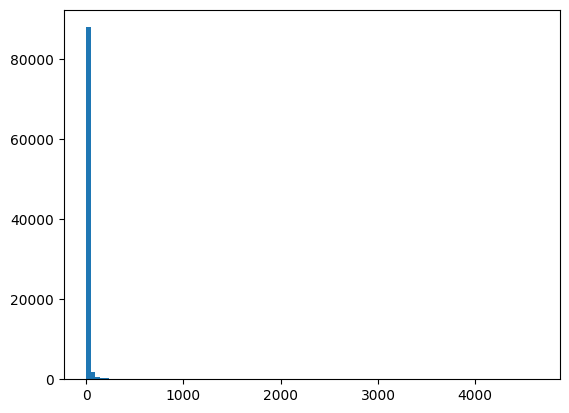

In [28]:
plt.hist(dot2[dot2>0].ravel().numpy(), bins=100);

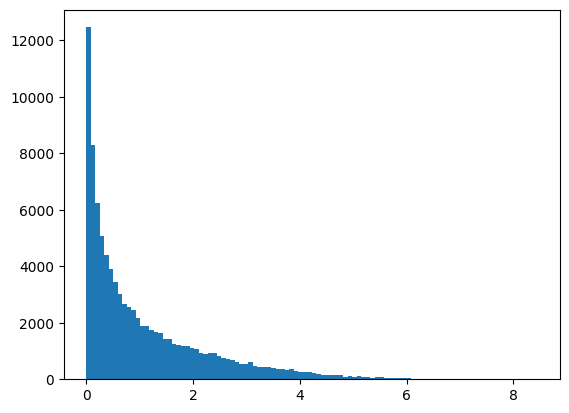

In [26]:
plt.hist(logdot2[logdot2>0].ravel().numpy(), bins=100);

Now we can create the permutation equivariant aggregations of our matrix of minkowski inner products.

In nanoPELICAN there is only a single such layer that operates on the inputs. Since for the top tagging dataset the individual constituents are treated as massless the diagonal of the dot matrix is 0 (traceless). Also it is symmetric. Therefore only 6 (out of 15) useful aggregations are left:

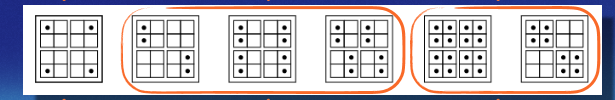

(from [ML4Jets2024 slides](https://indico.cern.ch/event/1253794/contributions/5588625/attachments/2748386/4783069/ML4Jets23_PELICAN.pdf))

we will follow that graphic and choose row sums:

In [29]:
logdot2.shape

torch.Size([32, 84, 84])

After each aggregation we should apply a scalefactor to control the overall scale of the numbers coming out. In the original paper a learnable parameter is used. Here we will just roughly use the average number of particles to control the scale:

In [30]:
# average number of particles - turns out to be roughly 50
np.mean([len(x) for x in arrays])

49.09737

In [31]:
sf = 1 / 50

All aggregations can be defined by the sum across all rows and the total sum:

In [34]:
rowsum = logdot2.sum(axis=1, keepdim=True) * sf
rowsum.shape

torch.Size([32, 1, 84])

In [38]:
totsum = logdot2.sum(axis=(1, 2), keepdim=True) * sf**2
totsum.shape

torch.Size([32, 1, 1])

In [36]:
N = batch["x"].shape[1]
N

84

In [39]:
totsum

tensor([[[0.1328]],

        [[1.1263]],

        [[0.4028]],

        [[1.1325]],

        [[1.4547]],

        [[0.4339]],

        [[0.7635]],

        [[1.4360]],

        [[1.5877]],

        [[2.0848]],

        [[0.6046]],

        [[0.0777]],

        [[1.0502]],

        [[1.7531]],

        [[1.0345]],

        [[1.2362]],

        [[3.1433]],

        [[1.5392]],

        [[0.8707]],

        [[1.0427]],

        [[0.6275]],

        [[1.1386]],

        [[1.7288]],

        [[1.6449]],

        [[0.4837]],

        [[0.2289]],

        [[2.2271]],

        [[2.3640]],

        [[1.1386]],

        [[2.1717]],

        [[1.7533]],

        [[1.6820]]])

We can use `torch.expand` to broadcast along dimensions of size 1, e.g. this will create a column vector with the total sum on each column:

In [40]:
totsum.expand(-1, N, -1)

tensor([[[0.1328],
         [0.1328],
         [0.1328],
         ...,
         [0.1328],
         [0.1328],
         [0.1328]],

        [[1.1263],
         [1.1263],
         [1.1263],
         ...,
         [1.1263],
         [1.1263],
         [1.1263]],

        [[0.4028],
         [0.4028],
         [0.4028],
         ...,
         [0.4028],
         [0.4028],
         [0.4028]],

        ...,

        [[2.1717],
         [2.1717],
         [2.1717],
         ...,
         [2.1717],
         [2.1717],
         [2.1717]],

        [[1.7533],
         [1.7533],
         [1.7533],
         ...,
         [1.7533],
         [1.7533],
         [1.7533]],

        [[1.6820],
         [1.6820],
         [1.6820],
         ...,
         [1.6820],
         [1.6820],
         [1.6820]]])

With this we can define all 6 aggregations:

In [42]:
torch.diag_embed(torch.tensor([[1,2,3,],[4,5,6]]))

tensor([[[1, 0, 0],
         [0, 2, 0],
         [0, 0, 3]],

        [[4, 0, 0],
         [0, 5, 0],
         [0, 0, 6]]])

In [43]:
agg0 = logdot2
agg1 = rowsum.expand(-1, N, -1)
agg2 = agg1.transpose(-1, -2)
agg3 = torch.diag_embed(rowsum.squeeze(1)) # put rowsum on diagonal
agg4 = totsum.expand(-1, N, N)
agg5 = torch.diag_embed(totsum.expand(-1, N, -1).squeeze(-1))

In [44]:
agg3.shape

torch.Size([32, 84, 84])

In [45]:
def six_aggs(x, sf=1/50):
    rowsum = x.sum(axis=1, keepdim=True) * sf
    totsum = x.sum(axis=(1, 2), keepdim=True) * sf**2
    N = x.shape[1]
    aggs = []
    aggs.append(x)
    aggs.append(rowsum.expand(-1, N, -1))
    aggs.append(aggs[0].transpose(-1, -2))
    aggs.append(torch.diag_embed(rowsum.squeeze(1)))
    aggs.append(totsum.expand(-1, N, N))
    aggs.append(torch.diag_embed(totsum.expand(-1, N, -1).squeeze(-1)))
    return torch.stack(aggs, -1)

In [46]:
aggs = six_aggs(logdot2)
aggs.shape

torch.Size([32, 84, 84, 6])

This is now the tensor that will be fed into a Linear layer!

After running it through the layer (before applying the global matrix to scalar aggregation) we need to set the masked values to 0 again. To do that we need to convert the mask square matrix form:

In [47]:
sq_mask = batch["mask"][:, :, np.newaxis] | batch["mask"][:, np.newaxis, :]
sq_mask[0]

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [49]:
sq_mask.shape

torch.Size([32, 84, 84])

Now we can implement the complete forward pass, according to this diagram:

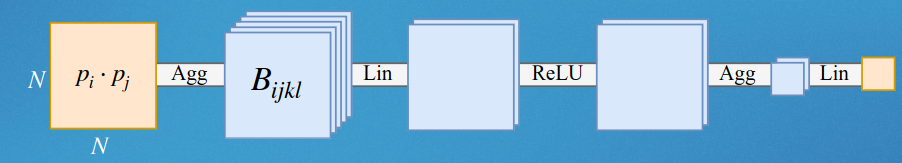

First Linear layer: it will reduce the 6 matrices with linear combinations resulting in 2 matrices and apply a relu activation function:

In [53]:
c = nn.Linear(6, 2)(aggs).relu()
c.shape

torch.Size([32, 84, 84, 2])

In [54]:
c = c.masked_fill(sq_mask[..., np.newaxis], 0) # set masked entries back to 0, new mask dimension
c.shape

torch.Size([32, 84, 84, 2])

Global matrix to scalar aggregation (sum and trace) for each of the 2 hidden matrices, resulting in 4 scalars:

In [56]:
c.diagonal(dim1=1, dim2=2).sum(-1).shape

torch.Size([32, 2])

In [57]:
ft = torch.cat(
    [
        (c.sum((1, 2)) * sf**2), # total sum
        c.diagonal(dim1=1, dim2=2).sum(-1) # trace
    ],
    -1
)
ft.shape

torch.Size([32, 4])

These can then be fed trough the final layer where we skip the activation function (will apply it in the loss). We get a single scalar value for each event in the batch:

In [58]:
nn.Linear(4, 1)(ft)

tensor([[1.2855],
        [0.4916],
        [0.9827],
        [0.4907],
        [0.4873],
        [0.7772],
        [0.4952],
        [0.4865],
        [0.4811],
        [0.4695],
        [0.5170],
        [1.3540],
        [0.4925],
        [0.4813],
        [0.4937],
        [0.4911],
        [0.3888],
        [0.4846],
        [0.4938],
        [0.4912],
        [0.5012],
        [0.4910],
        [0.4803],
        [0.4820],
        [0.5521],
        [1.2782],
        [0.4710],
        [0.4447],
        [0.4910],
        [0.4575],
        [0.4806],
        [0.4809]], grad_fn=<AddmmBackward0>)

Putting everything together as a single torch module:

In [59]:
class NanoPelican(nn.Module):
    def __init__(self, sf=1/50):
        super().__init__()
        self.linear1 = nn.Linear(6, 2)
        self.linear2 = nn.Linear(4, 1)
        self.sf = sf

    def forward(self, x, mask):
        mask = mask[:, :, np.newaxis] | mask[:, np.newaxis, :] # squared mask
        mask = mask[..., np.newaxis]
        x = x[:, :, np.newaxis] * x[:, np.newaxis, :] # pairwise prod
        x = x[..., 0] - x[..., 1:].sum(axis=-1) # minkowski dot squared
        x = x.clamp(0)
        x = torch.log(1 + x)
        x = six_aggs(x, sf=self.sf)
        x = self.linear1(x).relu().masked_fill(mask, 0)
        x = torch.cat([x.sum((1, 2)) * sf**2, x.diagonal(dim1=1, dim2=2).sum(-1) * sf], -1)
        x = self.linear2(x)
        return x

In [60]:
model = NanoPelican()

In [61]:
model(batch["x"], batch["mask"])

tensor([[0.0505],
        [0.4663],
        [0.1905],
        [0.4116],
        [0.5870],
        [0.1840],
        [0.2800],
        [0.6309],
        [0.8412],
        [0.9635],
        [0.2361],
        [0.0345],
        [0.4346],
        [0.7571],
        [0.4896],
        [0.5460],
        [1.5726],
        [0.6649],
        [0.3431],
        [0.3572],
        [0.2600],
        [0.4701],
        [0.7946],
        [0.8253],
        [0.1694],
        [0.0914],
        [0.8839],
        [1.2203],
        [0.4617],
        [1.1415],
        [0.7795],
        [0.7785]], grad_fn=<AddmmBackward0>)

And we end up with the impressively small amount of 19 parameters:

In [62]:
sum(par.numel() for par in model.parameters())

19

<div class="alert alert-block alert-success">
    <h2>Exercise 1: Check symmetries</h2>
Now is a good time to check if our model actually respects the symmetries we want it to have:

- invariance with/without padding (masking done correctly? no accidential cross batch operations?)
- permutation invariance
- lorentz invariance

You can use the code suggestions below and fill in the "..."
</div>

### Masking

In [86]:
x = batch["x"][0][~batch["mask"][0]][np.newaxis, :]
x.shape

torch.Size([1, 20, 4])

In [87]:
model(x, mask=torch.zeros((1, x.shape[1]), dtype=bool))

tensor([[0.0505]], grad_fn=<AddmmBackward0>)

In [91]:
out = []
for i in range(len(batch["x"])):
    x = batch["x"][i][~batch["mask"][i]][np.newaxis, :]
    out.append(model(x, mask=torch.zeros((1, x.shape[1]), dtype=bool)))

In [93]:
torch.isclose(torch.cat(out), model(batch["x"], mask=batch["mask"])).all()

tensor(True)

### Permutation invariance

In [68]:
x = batch["x"][10][np.newaxis, :]
mask = batch["mask"][10][np.newaxis, :]
before = model(x, mask)

In [72]:
x.shape

torch.Size([1, 84, 4])

In [70]:
rnd = np.random.permutation(x.shape[1])
rnd

array([75, 36, 25,  7, 19, 67, 24,  3, 20, 15, 16,  4, 43, 35,  9, 37, 33,
       28, 31, 70, 49, 69, 46, 44, 47,  1, 26, 27, 78, 52, 66, 71, 51, 56,
       54,  2, 76, 22, 65, 50, 39, 72, 45, 81, 60, 64, 48, 55, 42, 17,  0,
       83,  6, 32, 74, 73, 38, 77, 80, 79, 61, 29, 58, 14, 57, 41, 59, 18,
        5, 23, 40, 13, 10, 62, 11, 34, 30, 68, 53, 21, 82, 63,  8, 12])

In [74]:
x_after = x[:, rnd, :]
x_after.shape

torch.Size([1, 84, 4])

In [79]:
mask_after = mask[:, rnd]

In [80]:
after = model(x_after, mask_after)

In [81]:
torch.isclose(before, after)

tensor([[True]])

### Lorentz invariance

#### Rotations

In [63]:
# e.g. x-y plane
phi = torch.tensor(0.42)
# replace 0s in the matrix below to perform a rotation in the x-y plane
# by angle phi
rot = torch.tensor([[ 1,  0,  0,  0],
                    [ 0,  np.cos(phi),  -np.sin(phi),  0],
                    [ 0,  np.sin(phi),  np.cos(phi),  0],
                    [ 0,  0,  0,  1]])

In [64]:
# there may be numerical instabilities such that we don't get exact match
# still the largest difference shouldn't be too large
max(
    model(batch["x"], batch["mask"])
    - model(batch["x"] @ rot.T, batch["mask"])
)

tensor([1.2547e-05], grad_fn=<UnbindBackward0>)

#### Boost

In [65]:
beta = torch.tensor(0.7)
gamma = 1 / torch.sqrt(1 - beta**2)
boost = torch.tensor([[ gamma,  -beta*gamma,  0,  0],
                      [ -beta*gamma,  gamma,  0,  0],
                      [ 0,  0,  1,  0],
                      [ 0,  0,  0,  1]])

In [67]:
max(
    model(batch["x"] @ boost.T, batch["mask"])
    - model(batch["x"], batch["mask"])
)

tensor([3.7283e-05], grad_fn=<UnbindBackward0>)

## Fit the model

In [ ]:
# if GPU available
#model = NanoPelican()
#device = "cuda"
#model.to(device)

In [94]:
ds_train, ds_val = torch.utils.data.random_split(ds, [0.9, 0.1])
kwargs = dict(batch_size=32, collate_fn=collate_fn)
dl_train = DataLoader(ds_train, shuffle=True, **kwargs)
dl_val = DataLoader(ds_val, **kwargs)

In [95]:
optimizer = torch.optim.Adam(model.parameters())

In [96]:
from tqdm.auto import tqdm

In [97]:
history = []

In [98]:
def fit(model, optimizer, dl_train, dl_val, history, epochs=1):
    loss_fn = F.binary_cross_entropy_with_logits
    def forward(model, batch):
        return model(batch["x"], batch["mask"]).squeeze()

    def train_step(batch):
        #batch = {k: v.to(device) for k, v in batch.items()}
        model.train()
        optimizer.zero_grad()
        logits = forward(model, batch)
        loss = loss_fn(logits, batch["y"])
        loss.backward()
        optimizer.step()
        return loss.cpu().detach().item()

    def val_step(batch):
        #batch = {k: v.to(device) for k, v in batch.items()}
        model.eval()
        with torch.no_grad():
            logits = forward(model, batch)
            return loss_fn(logits, batch["y"]).cpu().item()

    for epoch in range(epochs):
        losses = []
        for batch in tqdm(dl_train):
            losses.append(train_step(batch))
        val_losses = []
        for batch in dl_val:
            val_losses.append(val_step(batch))
        history.append({"loss": np.mean(losses), "val_loss": np.mean(val_losses)})
        print(history[-1])

    return losses

In [99]:
fit(model, optimizer, dl_train, dl_val, history, epochs=5)

  0%|          | 0/2813 [00:00<?, ?it/s]

{'loss': 0.5758227694513448, 'val_loss': 0.5030608772279356}


  0%|          | 0/2813 [00:00<?, ?it/s]

{'loss': 0.4740509038352051, 'val_loss': 0.4515732661984599}


  0%|          | 0/2813 [00:00<?, ?it/s]

{'loss': 0.43670323666435434, 'val_loss': 0.4197290191254296}


  0%|          | 0/2813 [00:00<?, ?it/s]

{'loss': 0.40738949988539264, 'val_loss': 0.38762528208878855}


  0%|          | 0/2813 [00:00<?, ?it/s]

{'loss': 0.3814476803978101, 'val_loss': 0.368210943933493}


[0.38449469208717346,
 0.2986687421798706,
 0.27620643377304077,
 0.35617026686668396,
 0.42972150444984436,
 0.4612831473350525,
 0.29113560914993286,
 0.32173284888267517,
 0.351016104221344,
 0.469978004693985,
 0.40793377161026,
 0.4345032274723053,
 0.29180586338043213,
 0.465459406375885,
 0.29230502247810364,
 0.49271562695503235,
 0.5398313403129578,
 0.35014453530311584,
 0.36690449714660645,
 0.3717518448829651,
 0.329468309879303,
 0.30864715576171875,
 0.3946511745452881,
 0.34526413679122925,
 0.3914710581302643,
 0.5003491044044495,
 0.5126889944076538,
 0.4419477581977844,
 0.4164893627166748,
 0.24198180437088013,
 0.42136454582214355,
 0.4398709237575531,
 0.2476191222667694,
 0.3596840500831604,
 0.3007570207118988,
 0.3371506631374359,
 0.5243300199508667,
 0.36040544509887695,
 0.4905571937561035,
 0.3536812365055084,
 0.5258269906044006,
 0.3457033932209015,
 0.3115957975387573,
 0.3810637593269348,
 0.4154540002346039,
 0.42552104592323303,
 0.45690977573394775,
 

<Axes: >

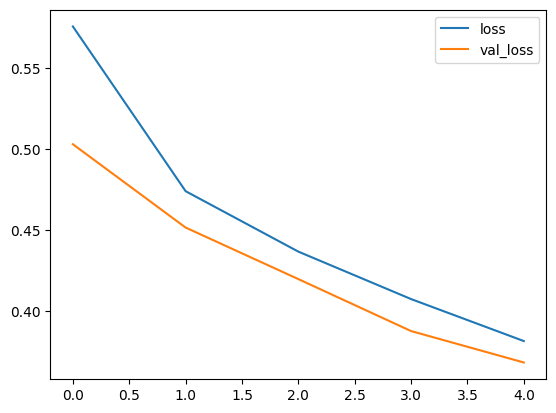

In [100]:
pd.DataFrame(history).plot()

## Evaluate performance

In [101]:
test_url = "https://syncandshare.lrz.de/dl/fiCvcfkzFWUFcBnToTjEVM/test_100k.npz"

In [102]:
arrays_test, y_test = load(test_url)

In [103]:
def evaluate(model, dl):
    y_pred = []
    model.eval()
    for batch in tqdm(dl):
        with torch.no_grad():
            # don't forget to apply sigmoid, as it's not in the model
            y_pred.append(model(batch["x"], mask=batch["mask"]).sigmoid().squeeze(1))
    return torch.cat(y_pred)

In [104]:
ds_test = Dataset(arrays_test, y_test)

In [105]:
y_pred = evaluate(model, DataLoader(ds_test, batch_size=32, collate_fn=collate_fn))

  0%|          | 0/3125 [00:00<?, ?it/s]

In [106]:
from sklearn.metrics import roc_curve, auc

In [110]:
fpr, tpr, thr = roc_curve(y_test, y_pred.numpy())

0.9046506251952504

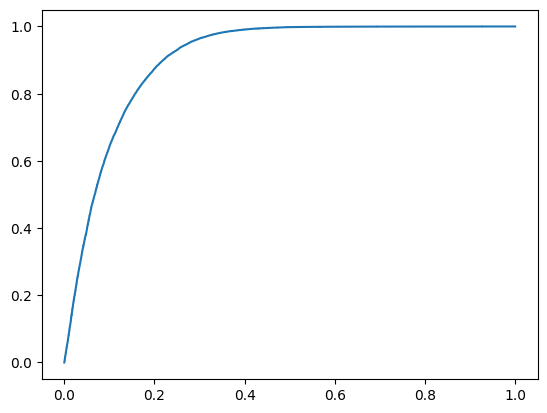

In [111]:
plt.plot(fpr, tpr)
auc(fpr, tpr)

C:\Users\maxge\AppData\Local\Temp\ipykernel_7280\1269438745.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr)
C:\Users\maxge\AppData\Local\Temp\ipykernel_7280\1269438745.py:3: RuntimeWarning: divide by zero encountered in divide
  (1 / fpr)[tpr>0.3].max()


27.954671088999447

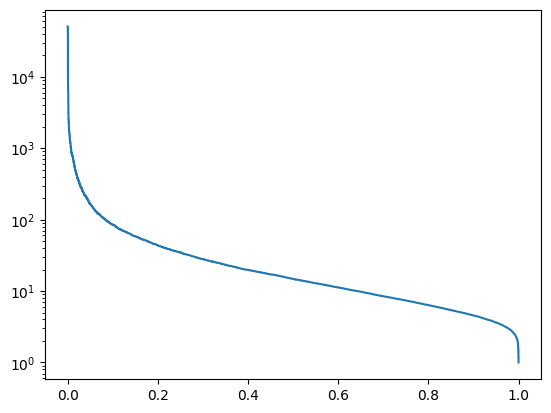

In [112]:
plt.plot(tpr, 1 / fpr)
plt.yscale("log")
(1 / fpr)[tpr>0.3].max()

<div class="alert alert-block alert-success">
<h2>Exercise 2 (extra): modify the model</h2>
You can now try to modify the model, e.g.

- Add a Dropout layer after the hidden layer (in the original implementation a rate of 0.05 is used)
- Increase or reduce the number of parameters
</div>